In [1]:
%matplotlib inline
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision as tv
from torchvision import transforms, utils
import glob
import pickle
import time

# PCA

Let's first briefly implement the Principal Component Analysis to illustrate how this works.

We are going to take the MNIST dataset again as our guinea pig as this will offer us some labels that we can use to illustrate the potential of PCA to form clusters in a lower-dimensional space.

First, we are going to load MNIST via torchvision, and transform the data back to numpy arrays.

For working with these for PCA we have to compress the 28x28 pixels images into vectors of 784 dimensions.

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = tv.datasets.MNIST(root='./',  train=True,download=True,transform=transform)
dataloaderSorted = torch.utils.data.DataLoader(
    trainset, batch_size=60000, shuffle=False, num_workers=4)

for n_batch, data in enumerate(dataloaderSorted):
    img, labels = data[0].detach().cpu().numpy(), data[1].detach().cpu().numpy()
    
    
# get rid of 1D channel dimension
img = np.squeeze(img)

# reshape to desired vectors
img = np.reshape(img,(60000,28*28))

IndentationError: unexpected indent (<ipython-input-2-10d6a8e38910>, line 8)

PCA requires input to be zero-centered and with a variance of 1. We are going to use sklearn for this

In [3]:
from sklearn.preprocessing import StandardScaler
std_img = StandardScaler().fit_transform(img)
print(std_img.shape)

(60000, 784)


Next we have to get the covariance matrix of the data

In [4]:
#find the co-variance matrix which is : A^T * A
sample_data = std_img

# matrix multiplication using numpy
covar_matrix = np.matmul(sample_data.T , sample_data)

print ( "The shape of variance matrix = ", covar_matrix.shape)

The shape of variance matrix =  (784, 784)


Next, we do PCA on the covariance matrix. We are not going to be interested in the actual PCA matrices that are created here, but rather only will take the Eigenvectors and Eigenvalues of the matrix, which we know to be the solutions of interest.

In [6]:
# finding the top two eigen-values and corresponding eigen-vectors 
# for projecting onto a 2D space.
# for this we use eigh

from scipy.linalg import eigh 

# the parameter 'eigvals' is defined (sorted low to high value) 
# eigh function will return the eigen values in ascending order
# this code generates only the top 2 (782 and 783) (index) eigenvalues.
values, vectors = eigh(covar_matrix, eigvals=(782,783))

print("Shape of eigen vectors = ",vectors.shape)
# converting the eigen vectors into (2D) shape
vectors = vectors.T

print("Updated shape of eigen vectors = ",vectors.shape)
# here the vectors[1] represent the eigen vector corresponding to 1st principal eigen vector
# here the vectors[0] represent the eigen vector corresponding to 2nd principal eigen vector

Shape of eigen vectors =  (784, 2)
Updated shape of eigen vectors =  (2, 784)


What do the eigenvectors look like? We can simply plot them as images like so:

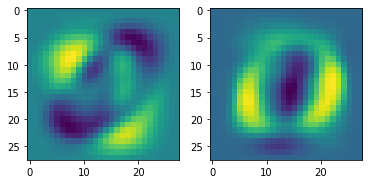

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(vectors[0,:].reshape(28,28))
ax2.imshow(vectors[1,:].reshape(28,28))

Next, we need to create the projections of our data in the new coordinate system defined by the two principal eigenvectors.

For this, we simply do the projection of Eigenvectors onto the transpose of the covariance matrix:

In [ ]:
# projecting the original data sample on the plane 
# formed by two principal eigen vectors by vector-vector multiplication.

new_coordinates = np.matmul(vectors, sample_data.T)

print ("projected data points' shape ", vectors.shape, "X", sample_data.T.shape," = ", new_coordinates.shape)

Now that we have all the data, we are going through it, digit-label by digit-label to create a 2D representation of the embedding of our data.

Note that we will need to do this by asking about the indices of each digit class, as the MNIST training set does not have equal numbers of examples in each digit class.

In [ ]:
plt.figure()
plt.hist(labels)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))


# go through each label
for l in np.arange(10):
    # find the indices
    inds = labels==l
    # select the correct vectors
    tmp = new_coordinates[:,inds]
    
    # and scatter giving the label as the digit string
    plt.scatter(tmp[0,:],tmp[1,:],label=str(l))

plt.legend()
plt.show()

Although we see some separation of digits, the individual clusters are not yet well defined. 

So, next, let's take a look at the non-linear dimensionality embedding methods offered via Autoencoders.

# Autoencoders

Autoencoders constitute perhaps the simplest class of generative models. 

To recap, in a generative model we learn the joint probability distribution of the input data and labels simultaneously, i.e. $P(x,y)$. This can be converted to $P(y|x)$ for classification via Bayes' rule, of course. Importantly, however, we can use $P(x,y)$ to create new samples $(x,y)$ that have highlikelihood.

So, how do we go about this from scratch? 

We have already seen encoders in our discussions of CNNs and fully-connected models for classification. They are simply taking data - let's say in image - and mapping it via a series of filters/feature detectors down to a (very) low dimensional label space (the output neurons).

We have also touched already on the idea of bottlenecks in our discussion of 1x1 convolutional filters for CNNs - the idea here was that we force the information through a lower-dimensional gate by weighted downsampling, followed by upsampling again.

Autoencoders are the natural extension of this idea with a low-dimensional bottleneck - the so-called latent space - inside an architecture that does: **Encoder (down-scaling) - bottleneck (latent space) - Decoder (up-scaling)**.

So, let's try this first with standard fully-connected layers:

## Autoencoders with fully-connected layers:

We need an Encoder - Bottleneck - Decoder architecture using fully-connected layers.

In [ ]:
class AE_FC(nn.Module):

    def __init__(self, latent_dim):
        super(AE_FC,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, latent_dim),
            nn.ReLU(True))

        self.decoder = nn.Sequential( 
            nn.Linear(latent_dim, 28*28),
            nn.Sigmoid())

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    # we define this function so we can access only the
    # latent space of the model
    def getlatent(self,x):
        x = self.encoder(x)
        return x

## Autoencoders on MNIST

We are going to apply the autoencoders on the MNIST. The reason for this is that MNIST has 10 different classes of digits, which will allow us later to try to visualize what is going on in that latent (bottleneck) space.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = tv.datasets.MNIST(root='./',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=1)
testset = tv.datasets.MNIST(root='./', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=1)

This is a quick helper function to combine 20 images of original and predicted pictures into one picture for display:

In [ ]:
def convertBatchToCombined(inp,out):
    # this should be extended to arbitrary batch length
    # assuming this to be 10 here
    combinedUp = np.zeros((28,28*10))
    combinedDown = np.zeros((28,28*10))
    for b in np.arange(10):
        combinedUp[:,b*28:b*28+28]=np.reshape(inp[:,b],(28,28))
        combinedDown[:,b*28:b*28+28]=np.reshape(out[:,b],(28,28))
    tmp = np.vstack([combinedUp,combinedDown])
    tmp = (tmp-tmp.min())/(tmp.max()-tmp.min())*255.
    return(np.repeat(tmp[:,:,np.newaxis], 3, axis=2))


our friendly real-time update function:

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact
fig = make_subplots(rows=1, cols=1)
fig.append_trace(go.Image(z=np.zeros((28,28*10,3))),row=1,col=1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
)
fig

Let's try this autoencoder with a latent dimensionality of d=10:

In [ ]:
num_epochs = 5
model = AE_FC(10)

# put to device
device = (torch.device('cuda') if torch.cuda.is_available()
    else torch.device('cpu'))

model.to(device=device)

# use MSE loss
distance = nn.MSELoss()

# standard ADAM
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# pre-load the test pictures for visualization of online prediction
timg, tlabels = list(dataloader)[0]
timg = timg.to(device)
timg = timg.view(timg.size(0), -1)

# training loop
for epoch in range(num_epochs):
    for n_batch, data in enumerate(dataloader):
        # we don't need the labels here
        img, labels = data[0].to(device), data[1].to(device)
        
        # flatten
        img = img.view(img.size(0), -1)
        # ===================forward=====================
        output = model(img)
        loss_mse = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()
        
        # visualize output
        if (n_batch) % 50 == 0:
            with torch.no_grad():
                output = model(timg)
                inp = timg[0:10, :].detach().cpu()
                out = output[0:10, :].detach().cpu()

                combined = convertBatchToCombined(inp.permute(1,0),out.permute(1,0))
                
                with fig.batch_update():
                    fig.data[0]['z'] = combined
                    fig.update_layout(
                        title={
                            'text':'epoch {0:} batch {1:} L={2: .3f}'.format(
                                epoch+1,n_batch,loss_mse.item()),
                            'xanchor':'center',
                            'x':0.5
                        })
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss_mse.item()))

As we can see, the reconstructions of the digits start out noisy and then converge to a somewhat blurred representation. Our autoencoder is a bit "shallow", however, with only one hidden layer that does the heavy lifting of discovering features.

How about going "deeper"?

In [ ]:
class AE_FC_deep(nn.Module):

    def __init__(self, latent_dim):
        super(AE_FC_deep,self).__init__()
        
        self.encoder = nn.Sequential(
            
            nn.Linear(28*28, 512),
            nn.ReLU(True),
            nn.Linear(512,128),
            nn.ReLU(True),
            nn.Linear(128,latent_dim),
            nn.ReLU(True))

        self.decoder = nn.Sequential( 
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128,512),
            nn.ReLU(True),
            nn.Linear(512, 28*28),
            nn.Sigmoid())

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    # we define this function so we can access only the
    # latent space of the model
    def getlatent(self,x):
        x = self.encoder(x)
        return x

In [ ]:
num_epochs = 5
model = AE_FC_deep(10)

# put to device
device = (torch.device('cuda') if torch.cuda.is_available()
    else torch.device('cpu'))

model.to(device=device)

# use MSE loss
distance = nn.MSELoss()

# standard ADAM
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# pre-load the test pictures for visualization of online prediction
timg, tlabels = list(dataloader)[0]
timg = timg.to(device)
timg = timg.view(timg.size(0), -1)

# training loop
for epoch in range(num_epochs):
    for n_batch, data in enumerate(dataloader):
        # we don't need the labels here
        img, labels = data[0].to(device), data[1].to(device)
        
        # flatten
        img = img.view(img.size(0), -1)
        # ===================forward=====================
        output = model(img)
        loss_mse = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()
        
        # visualize output
        if (n_batch) % 50 == 0:
            with torch.no_grad():
                output = model(timg)
                inp = timg[0:10, :].detach().cpu()
                out = output[0:10, :].detach().cpu()

                combined = convertBatchToCombined(inp.permute(1,0),out.permute(1,0))
                
                with fig.batch_update():
                    fig.data[0]['z'] = combined
                    fig.update_layout(
                        title={
                            'text':'epoch {0:} batch {1:} L={2: .3f}'.format(
                                epoch+1,n_batch,loss_mse.item()),
                            'xanchor':'center',
                            'x':0.5
                        })
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss_mse.item()))

And that works better, resulting in sharper, more well-defined reconstructions of the digits. 

We were talking about the latent space, however - how can we visualize this nicely? 

How about we force the latent, bottleneck layer to be two-dimensional, so that we can visualize all digits in this two-dimensional space?

In [ ]:
num_epochs = 5

# let's make things two-dimensional!
model = AE_FC_deep(2)

# put to device
device = (torch.device('cuda') if torch.cuda.is_available()
    else torch.device('cpu'))

model.to(device=device)

# use MSE loss
distance = nn.MSELoss()

# standard ADAM
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# pre-load the test pictures for visualization of online prediction
timg, tlabels = list(dataloader)[0]
timg = timg.to(device)
timg = timg.view(timg.size(0), -1)

# training loop
for epoch in range(num_epochs):
    for n_batch, data in enumerate(dataloader):
        # we don't need the labels here
        img, labels = data[0].to(device), data[1].to(device)
        
        # flatten
        img = img.view(img.size(0), -1)
        # ===================forward=====================
        output = model(img)
        loss_mse = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()
        
        # visualize output
        if (n_batch) % 50 == 0:
            with torch.no_grad():
                output = model(timg)
                inp = timg[0:10, :].detach().cpu()
                out = output[0:10, :].detach().cpu()

                combined = convertBatchToCombined(inp.permute(1,0),out.permute(1,0))
                
                with fig.batch_update():
                    fig.data[0]['z'] = combined
                    fig.update_layout(
                        title={
                            'text':'epoch {0:} batch {1:} L={2: .3f}'.format(
                                epoch+1,n_batch,loss_mse.item()),
                            'xanchor':'center',
                            'x':0.5
                        })
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss_mse.item()))

Now that we have a two-dimensional latent space, let's poll it with our full dataset of 60000 digits to see what it looks like.

For this, we first create a non-shuffled `DataLoader` that simply loads **all** MNIST training digits into memory - including the labels.

In [ ]:
dataloaderSorted = torch.utils.data.DataLoader(trainset, batch_size=60000, shuffle=False, num_workers=4)

for n_batch, data in enumerate(dataloaderSorted):
    img, labels = data[0].to(device), data[1].detach().cpu().numpy()

Now that we have all the data, we are going through it, digit-label by digit-label to create a 2D representation of the embedding of our data.

Note that we will need to do this by asking about the indices of each digit class, as the MNIST training set does not have equal numbers of examples in each digit class.

In [ ]:
plt.figure()
plt.hist(labels)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))

# don't forget to do this
model.eval()

# go through each label
for l in np.arange(10):
    # find the indices
    inds = labels==l
    # select the images
    tmp = img[inds,:,:,:]
    # flatten them
    tmp = tmp.view(tmp.size(0), -1)
    # put them through the model to get their 2D latent
    # space representation
    output = model.getlatent(tmp).detach().cpu().numpy()
    
    # and scatter giving the label as the digit string
    plt.scatter(output[:,0],output[:,1],label=str(l))

plt.legend()
plt.show()

As we can see that worked out "fine" to some degree - we do not see clusters of digits, but rather "rays" of digits, with some degree of clustering.